[*********************100%***********************]  1 of 1 completed


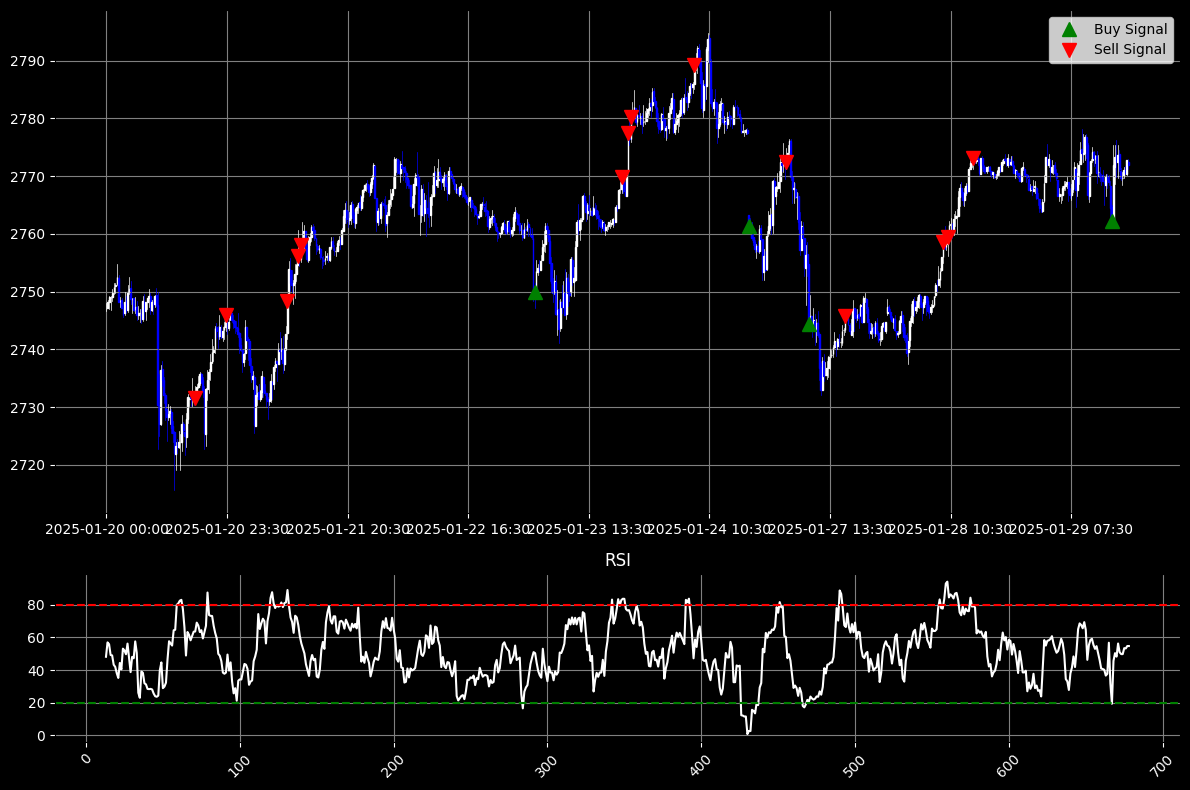

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
from datetime import datetime, timedelta

def financieal_rsi_bot():

    end_date = datetime.now()
    start_date = end_date - timedelta(days=10)
    
    data = yf.download('GC=F', start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), interval='15m')
    data.reset_index(inplace=True)
    data = data[data['Datetime'].dt.weekday < 5]
    data['Continuous_Index'] = range(len(data))
    
    ohlc_data = data[['Continuous_Index', 'Open', 'High', 'Low', 'Close']].values
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]}, facecolor='black')
    ax1.set_facecolor('black')
    
    candlestick_ohlc(ax1, ohlc_data, width=0.6, colorup='white', colordown='blue')
    
    ax1.xaxis.set_major_locator(plt.MaxNLocator(10))  
    def format_date(x, _):
        if x < 0 or x >= len(data):
            return ''
        return data['Datetime'].iloc[int(x)].strftime('%Y-%m-%d %H:%M')
    
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_date))
    plt.xticks(rotation=45, color='white')
    
    ax1.grid(True, color='gray')
    ax1.tick_params(axis='x', colors='white')
    ax1.tick_params(axis='y', colors='white')
    
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi

    data['avg_volume'] = data['Volume'].rolling(window=14).mean()
    
    data['buy_signal'] = (data['RSI'] < 20) & (data['RSI'].shift(1) >= 20) 
    data['sell_signal'] = (data['RSI'] > 80) & (data['RSI'].shift(1) <= 80)
    
    ax2.set_facecolor('black')
    ax2.set_title('RSI', color='white')
    ax2.plot(data['Continuous_Index'], data['RSI'], color='white')
    ax2.axhline(80, color='red', linestyle='--')
    ax2.axhline(20, color='green', linestyle='--')
    ax2.grid(True, color='gray')
    ax2.tick_params(axis='x', colors='white')
    ax2.tick_params(axis='y', colors='white')
    
    ax1.plot(data.loc[data['buy_signal'], 'Continuous_Index'], data.loc[data['buy_signal'], 'Close'], '^', markersize=10, color='green', label='Buy Signal')
    ax1.plot(data.loc[data['sell_signal'], 'Continuous_Index'], data.loc[data['sell_signal'], 'Close'], 'v', markersize=10, color='red', label='Sell Signal')
    ax1.legend()
    
    plt.tight_layout()
    plt.show()

financieal_rsi_bot()